In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
#LOADING IMAGES IN THE GIVEN DIRECTORY

def import_images():
    files       = os.listdir("camera_cal/")
    uncalib_img = mpimg.imread("camera_cal/"+files[0])
    uncalib_img = np.expand_dims(uncalib_img, axis = 0)
    ind         = 1

    for i in files[1:]:

        files[ind] = "camera_cal/"+i
        tmp_uncalib_img    = mpimg.imread(files[ind])

        if not(uncalib_img.shape[1:] == tmp_uncalib_img.shape):
            tmp_uncalib_img = cv2.resize(tmp_uncalib_img,(1280, 720), interpolation = cv2.INTER_LINEAR)
            tmp_uncalib_img = np.array(tmp_uncalib_img)

        tmp_uncalib_img = np.expand_dims(tmp_uncalib_img, axis = 0)
        uncalib_img     = np.concatenate((uncalib_img,tmp_uncalib_img), axis = 0)
        ind             = ind + 1

    return uncalib_img, files

In [3]:
def cal_undistort(img, objpoints, imgpoints, objp, nx, ny):
    
    gray         = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    undist       = img
    mtx          = None
    dist         = None

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
    return undist, mtx, dist


In [4]:
def camera_calibration(uncalib_img, print_flag = False, pic_flag = False):
    objpoints   = []
    imgpoints   = []
    nx, ny      = 9, 6
    objp        = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2]  = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    for j in range(2):

        index = 0

        for im in uncalib_img:
            
            if print_flag:
                            
                print('Current Index: ', index)
                index = index + 1
            
            calib_img = np.copy(im)
            undistort, mtx, dist = cal_undistort(calib_img, objpoints, imgpoints, objp, nx, ny)
            
        if pic_flag:
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undistort)
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return mtx, dist

In [5]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):

    gray = np.copy(img)
    
    orientx = (orient == 'x')
    orienty = (orient == 'y')
    
    sobel        = cv2.Sobel(gray, cv2.CV_64F, orientx, orienty)
    abs_sobel    = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary





#########################
#### FINAL PIPELINE #####
#########################

def pipeline(img, s_thresh=(175, 250), sxy_thresh=(30, 150), ksize = 11):
      
    # Convert to HSV color space and separate the V channel
    hsv  = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    
    s_channel = hsv[:,:,2]    
    
    # Apply each of the thresholding functions
    gradx      = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh = sxy_thresh)
    
    ## Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(s_binary), gradx ,s_binary))
    
    return color_binary

In [7]:
def warped_image(img, src, dst):
    
    img_shape = img.shape[0:2]
    M         = cv2.getPerspectiveTransform(src, dst)
    Minv      = cv2.getPerspectiveTransform(dst, src)
    warped    = cv2.warpPerspective(img, M, img_shape[::-1], flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

In [8]:
def fit_lanes(img, error = 0, left_fit = [], right_fit = [], margin = 100):
    
    binary_warped = np.copy(img)
    
    if error:
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    else:
    
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
    #         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    #         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)


        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [9]:
def find_curvature(ploty, left_fit, right_fit):

    # Define y-value where we want radius of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


In [10]:
def pixel_2_length(ploty, left_fit, right_fit):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad

In [76]:
def dist_from_center(img, left_lane_pixel, right_lane_pixel):
    
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        screen_middel_pixel = img.shape[1]/2
        car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
        pixels_off_center = screen_middel_pixel-car_middle_pixel
        cm_off_center = xm_per_pix * pixels_off_center*100
        
        return cm_off_center

In [85]:
def final_image_gen(undist_img, warped, ploty, left_fit, right_fit, Minv, L, R, C):

    img_shape = undist_img.shape[0:2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_shape[::-1])) 
    # Combine the result with the original image
    final_result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    final_result = cv2.putText(final_result, L, (10,50), font, 1.1, (255,255,255), 2)
    final_result = cv2.putText(final_result, R, (850,50), font, 1.1, (255,255,255), 2)
    final_result = cv2.putText(final_result, C, (10,150), font, 1.1, (255,255,255), 2)
    
    return final_result

Loading Images..
Images Loaded

This image is: <class 'numpy.ndarray'> with dimesions: (20, 720, 1280, 3)
Index:  0 ; File Name:  calibration1.jpg
Index:  1 ; File Name:  camera_cal/calibration10.jpg
Index:  2 ; File Name:  camera_cal/calibration11.jpg
Index:  3 ; File Name:  camera_cal/calibration12.jpg
Index:  4 ; File Name:  camera_cal/calibration13.jpg
Index:  5 ; File Name:  camera_cal/calibration14.jpg
Index:  6 ; File Name:  camera_cal/calibration15.jpg
Index:  7 ; File Name:  camera_cal/calibration16.jpg
Index:  8 ; File Name:  camera_cal/calibration17.jpg
Index:  9 ; File Name:  camera_cal/calibration18.jpg
Index:  10 ; File Name:  camera_cal/calibration19.jpg
Index:  11 ; File Name:  camera_cal/calibration2.jpg
Index:  12 ; File Name:  camera_cal/calibration20.jpg
Index:  13 ; File Name:  camera_cal/calibration3.jpg
Index:  14 ; File Name:  camera_cal/calibration4.jpg
Index:  15 ; File Name:  camera_cal/calibration5.jpg
Index:  16 ; File Name:  camera_cal/calibration6.jpg
Ind

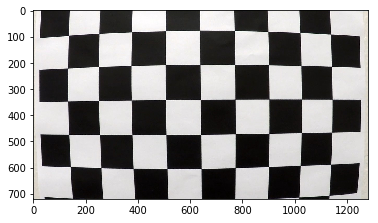

In [91]:
print('Loading Images..')

uncalib_img, files = import_images()

print('Images Loaded')
print()
print('This image is:', type(uncalib_img), 'with dimesions:', uncalib_img.shape)

index = 0
for i in files:
    print('Index: ',index, '; File Name: ', i)
    index = index + 1
    
## PLOT TEST IMAGES
print()
print('Test Image')
plt.imshow(uncalib_img[0])

In [50]:
mtx, dist = camera_calibration(uncalib_img, print_flag = True, pic_flag = False)

print()
print('Final Camera Matrix: ')
print(mtx)

Current Index:  0
Current Index:  1
Current Index:  2
Current Index:  3
Current Index:  4
Current Index:  5
Current Index:  6
Current Index:  7
Current Index:  8
Current Index:  9
Current Index:  10
Current Index:  11
Current Index:  12
Current Index:  13
Current Index:  14
Current Index:  15
Current Index:  16
Current Index:  17
Current Index:  18
Current Index:  19
Current Index:  0
Current Index:  1
Current Index:  2
Current Index:  3
Current Index:  4
Current Index:  5
Current Index:  6
Current Index:  7
Current Index:  8
Current Index:  9
Current Index:  10
Current Index:  11
Current Index:  12
Current Index:  13
Current Index:  14
Current Index:  15
Current Index:  16
Current Index:  17
Current Index:  18
Current Index:  19

Final Camera Matrix: 
[[  1.15431047e+03   0.00000000e+00   6.71781143e+02]
 [  0.00000000e+00   1.14825667e+03   3.85641681e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


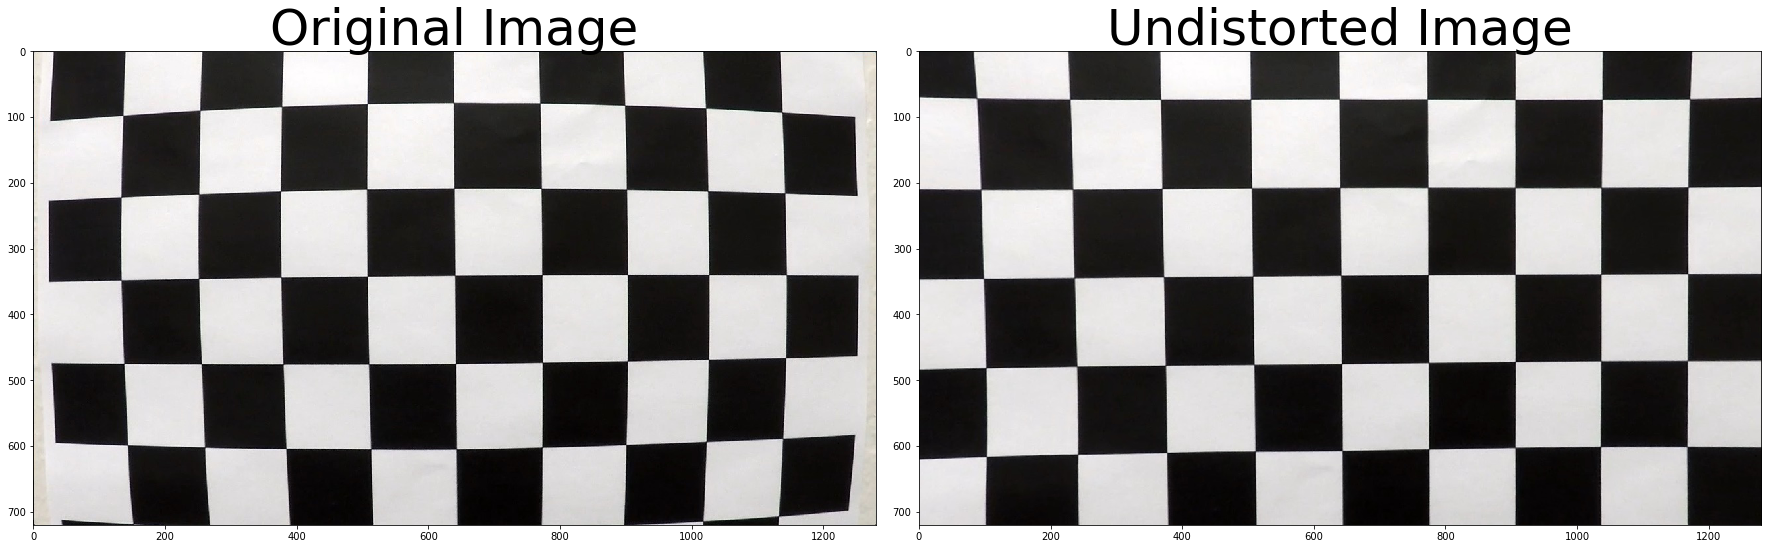

In [92]:
plot_img = undistort_image(uncalib_img[0], mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(uncalib_img[0])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(plot_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [93]:
#LOADING CAR CAMERA TEST IMAGES IN THE GIVEN DIRECTORY

print('Loading Test Images..')
test_files   = os.listdir("test_images/")
test_image   = mpimg.imread("test_images/"+test_files[0])
test_image   = np.expand_dims(test_image, axis = 0)
ind          = 1

for i in test_files[1:]:
    test_files[ind] = "test_images/"+i
    tmp_test_img    = mpimg.imread(test_files[ind])
    if not(test_image.shape[1:] == tmp_test_img.shape):
        tmp_test_img = cv2.resize(tmp_test_img,(1280, 720), interpolation = cv2.INTER_LINEAR)
        tmp_test_img = np.array(tmp_test_img)
        
    tmp_test_img = np.expand_dims(tmp_test_img, axis = 0)
    test_image   = np.concatenate((test_image,tmp_test_img), axis = 0)
    ind          = ind + 1

print('Images Loaded')
print()
print('This image is:', type(test_image), 'with dimesions:', test_image.shape)

Loading Test Images..
Images Loaded

This image is: <class 'numpy.ndarray'> with dimesions: (8, 720, 1280, 3)


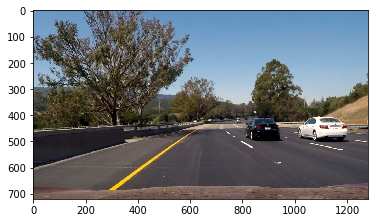

In [94]:
## PLOT TEST IMAGES

plt.imshow(test_image[7])

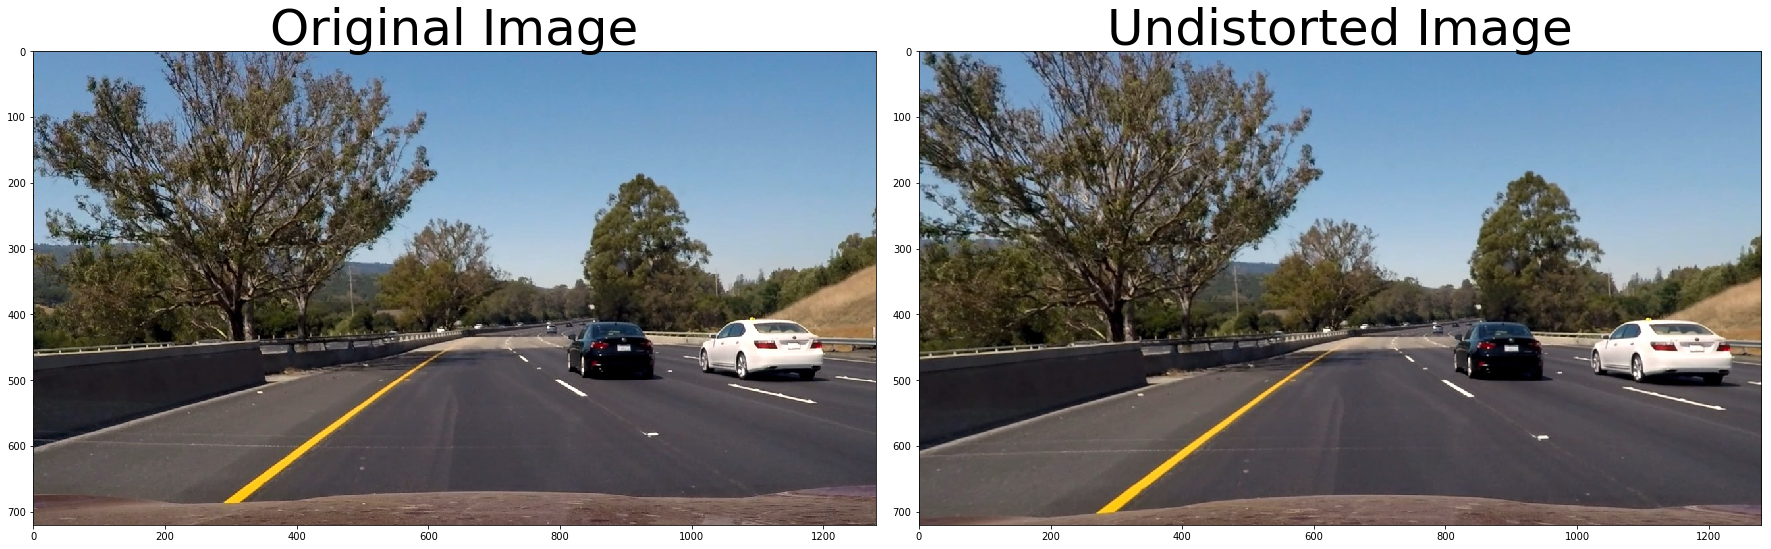

In [95]:
index = 0

for i in test_image: 
    orig_img = np.copy(i)
    tmp_undist_img = undistort_image(orig_img, mtx, dist)
    tmp_undist_img = np.expand_dims(tmp_undist_img, axis = 0)
    
    if index == 0:
        undistorted = tmp_undist_img
    else:
        undistorted = np.concatenate((undistorted,tmp_undist_img), axis = 0)
    
    index = index + 1

plot_index = 7
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image[plot_index])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted[plot_index])
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

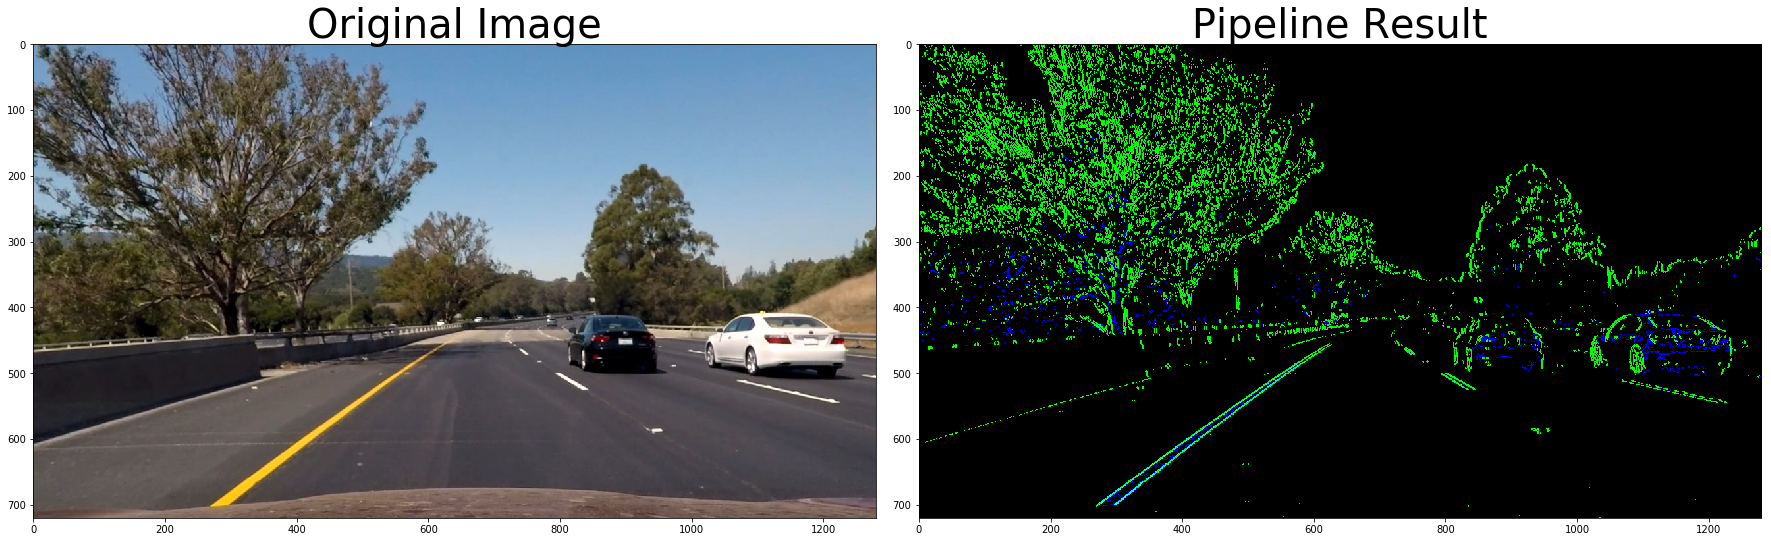

In [96]:
img_undist   = np.copy(undistorted[plot_index])
pipln_result = pipeline(img_undist)

## Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img_undist)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(pipln_result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

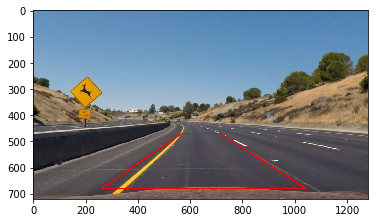

In [75]:
img_undist = np.copy(undistorted[plot_index])
marked_img = np.copy(img_undist)
color      = [255, 0, 0]
thickness  = 4

v = np.array([[(575,460),(203, 720), (1127, 720), (705, 460)]], dtype=np.int32)
v = np.array([[(568,470),(717, 470), (1043, 680), (260, 680)]], dtype=np.int32)

for i in range(4):     
    marked_img = cv2.line(marked_img, (v[0,i,0], v[0,i,1]), (v[0,(i+1)%4,0], v[0,(i+1)%4,1]), color, thickness)

plt.imshow(marked_img)

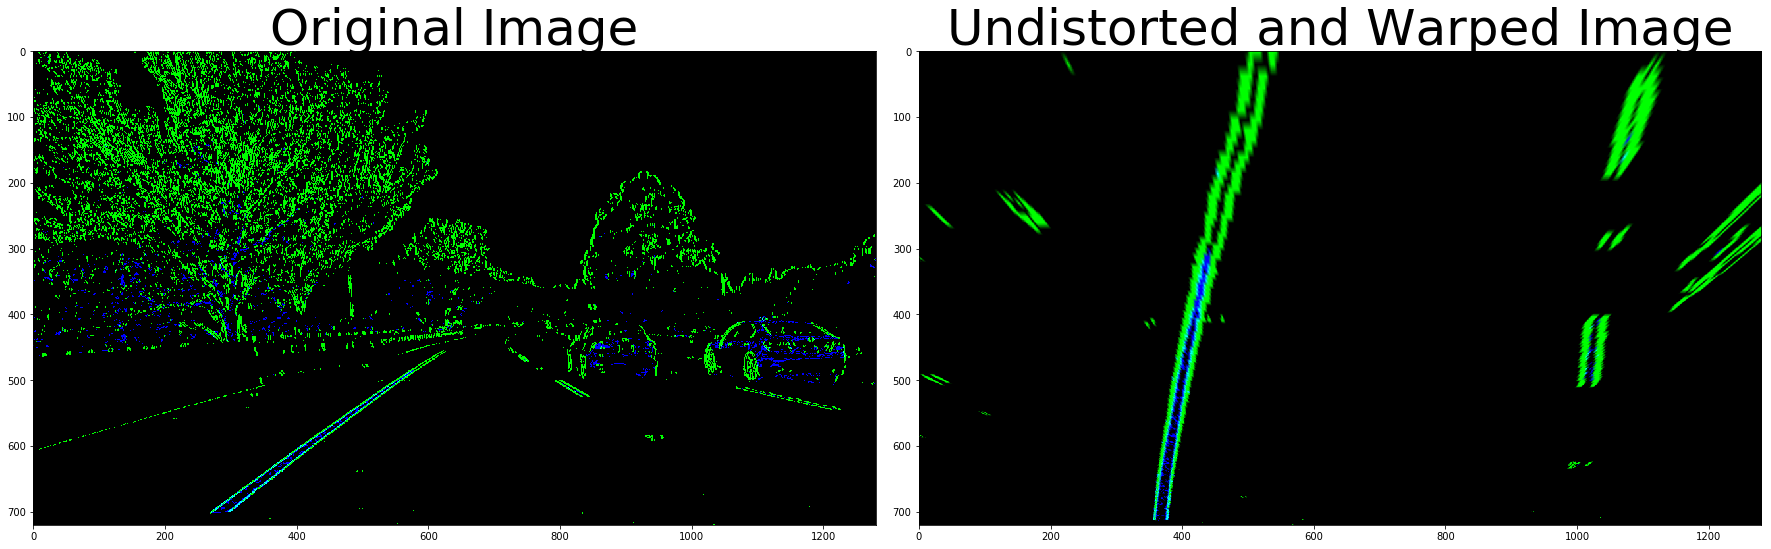

In [97]:
## Jseph Abad's source points

# img = np.copy(undistorted[plot_index])
img_pipln = np.copy(pipln_result)
img_shape = img_pipln.shape[0:2]
color     = [255, 0, 0]
thickness = 4

src = np.float32([[575, 460],[190,720],[1127,720],[705,460]])
dst = np.float32([[320,0],[320,720],[960,720],[960,0]])

M, Minv, warped = warped_image(img_pipln, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_pipln)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(720, 1280)


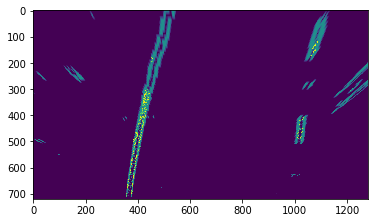

In [98]:
img_bit_warped = cv2.bitwise_or(warped[:,:,1], warped[:,:,2])
print(img_bit_warped.shape)
plt.imshow(img_bit_warped)

(1280,)


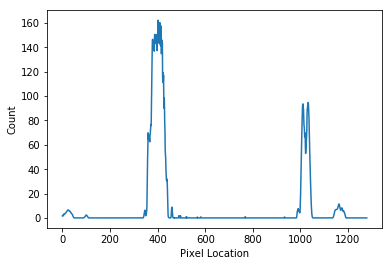

In [99]:
binary_warped = np.copy(img_bit_warped)
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
print(histogram.shape)

plt.figure(1)
plt.plot(histogram)
plt.ylabel('Count')
plt.xlabel('Pixel Location')
plt.show()

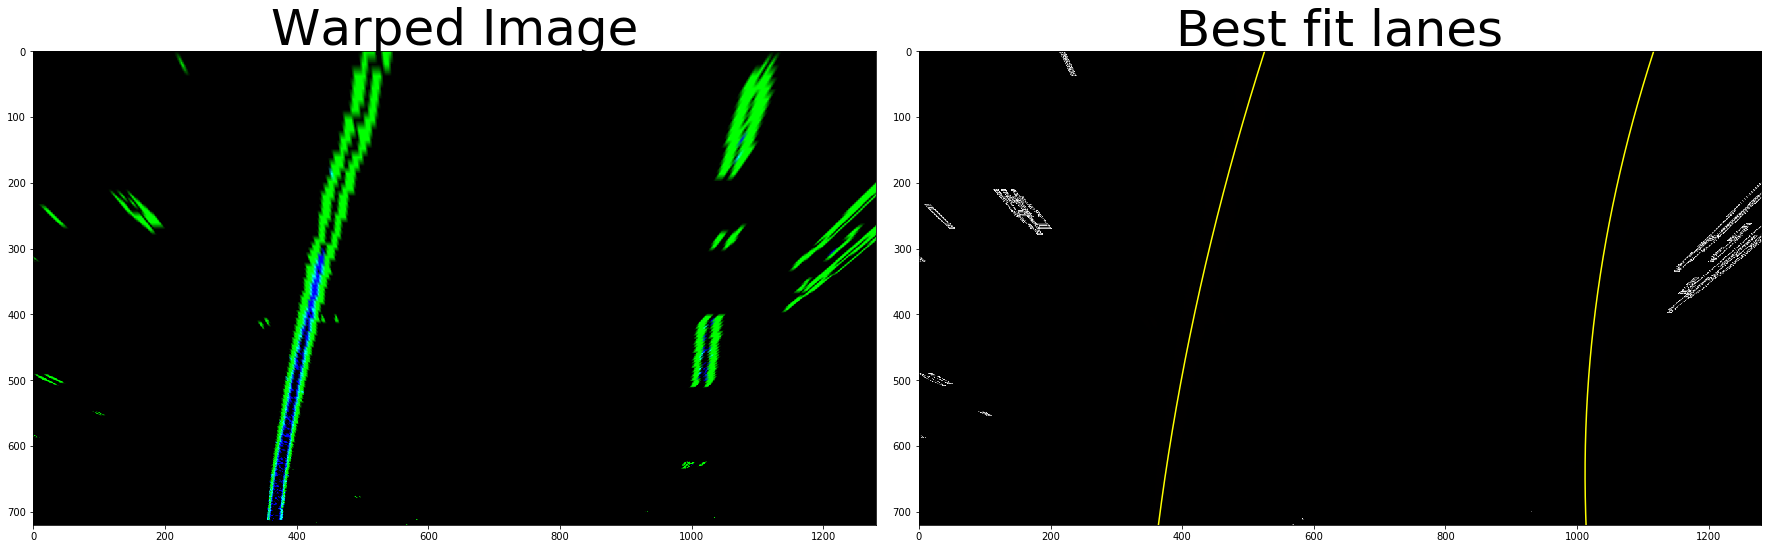

In [103]:
# Create an output image to draw on and  visualize the result

left_fit, right_fit, left_lane_inds, right_lane_inds= fit_lanes(binary_warped)

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize=50)
ax2.imshow(out_img)
ax2.set_title('Best fit lanes', fontsize=50)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


3849.29962217 1984.23778172
1234.10817851 m 650.293907786 m


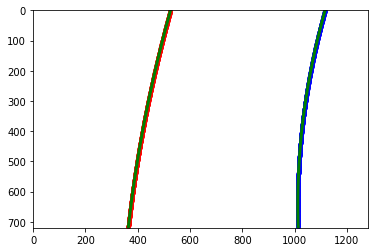

In [105]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image

left_curverad, right_curverad = find_curvature(ploty, left_fit, right_fit)
print(left_curverad, right_curverad)


left_curverad, right_curverad = pixel_2_length(ploty, left_fit, right_fit)
print(left_curverad, 'm', right_curverad, 'm')

leftx  = left_fitx
rightx = right_fitx

# Plot up the data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

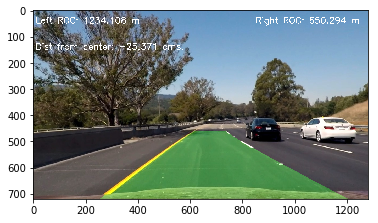

In [108]:
tmp_img_final = np.copy(undistorted[plot_index])

center = dist_from_center(binary_warped, leftx[719], rightx[719])

L, R, C = "{:.3f}".format(left_curverad) , "{:.3f}".format(right_curverad) , "{:.3f}".format(center) 
L = "Left ROC: "+L+" m"
R = "Right ROC: "+R+" m"
C = "Dist from center: "+C+" cms."

final_result = final_image_gen(tmp_img_final, binary_warped, ploty, left_fit, right_fit, Minv, L, R, C)

plt.imshow(final_result)

In [ ]:
## CALIBRATING THE CAMERA


print("Calibrating Camera...")
uncalib_img, files = import_images()
mtx, dist = camera_calibration(uncalib_img)
print()
print("Calibrated.")

with open('camera.p', 'wb') as f:
    pickle.dump({'mtx': mtx, 
                 'dist': dist},f, protocol = 2)

In [87]:
def process_image(image):
    
    error = 1
    
    global prev
    
    try:
        prev
    except:
        error = 0
    
    img                 = np.copy(image)    
    undist_img          = undistort_image(img, mtx, dist)
    pipeline_img        = pipeline(undist_img)
    M, Minv, warped_img = warped_image(pipeline_img, src, dst)
    bit_warped_img      = cv2.bitwise_or(warped_img[:,:,1], warped_img[:,:,2])
    
    if error:

        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lanes(bit_warped_img, error, prev[0], prev[1], margin = 50)
        
        left_diff  = np.abs(prev[0] - left_fit)
        right_diff = np.abs(prev[1] - right_fit)      
        left_diff  = np.sum(left_diff)/left_diff.shape[0]
        right_diff = np.sum(right_diff)/right_diff.shape[0]
        allow      = 5.
        
        tmp1 = left_fit
        tmp2 = right_fit
        
#         print(left_diff, right_diff)
        
        if left_diff > allow or right_diff > allow:
            
            left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lanes(bit_warped_img, error, prev[4], prev[5])
            
            left_diff  = np.abs(prev[0] - left_fit)
            right_diff = np.abs(prev[1] - right_fit)      
            left_diff  = np.sum(left_diff)/left_diff.shape[0]
            right_diff = np.sum(right_diff)/right_diff.shape[0]

            if left_diff > allow:
                left_fit = prev[4]  
            else:
                left_fit = 0.9*left_fit + 0.1*prev[0]  
                tmp1     = left_fit
                prev[4]  = left_fit
                
            if right_diff > allow:
                right_fit = prev[5]
            else:
                right_fit = right_fit = 0.9*right_fit + 0.1*prev[1]
                tmp2      = right_fit
                prev[5]   = right_fit
                
            prev[0] = tmp1
            prev[1] = tmp2

        else:        
            left_fit  = 0.9*left_fit + 0.1*prev[0]
            right_fit = 0.9*right_fit + 0.1*prev[1] 
            
            prev[0] = left_fit
            prev[1] = right_fit
            prev[4] = left_fit
            prev[5] = right_fit
            

#             prev[2].append([left_fit])
#             prev[3].append([right_fit])
        
#         if len(prev[2]) > 10:
#             del prev[2][0]
#             del prev[3][0]
        
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_lanes(bit_warped_img)
        ## prev = [last_coeff, last_coeff, last_5, last_5, best_coeff, best_coeff]
        prev = [left_fit, right_fit, [[left_fit]], [[right_fit]], left_fit, right_fit]
        
    
    ploty = np.linspace(0, 719, num=720)
    left_curverad, right_curverad = find_curvature(ploty, left_fit, right_fit)
    left_curverad, right_curverad = pixel_2_length(ploty, left_fit, right_fit)
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    center = dist_from_center(bit_warped_img, leftx[719], rightx[719])
    
    L, R, C = "{:.3f}".format(left_curverad) , "{:.3f}".format(right_curverad) , "{:.3f}".format(center) 
    L = "Left ROC: "+L+" m"
    R = "Right ROC: "+R+" m"
    C = "Dist from center: "+C+" cms."

    final_image = final_image_gen(img, bit_warped_img, ploty, left_fit, right_fit, Minv, L, R, C)
    
    
    return final_image

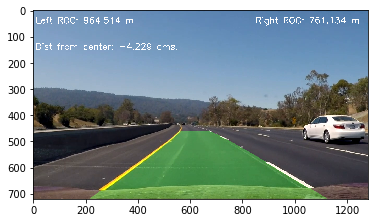

In [88]:
with open('camera.p', 'rb') as f:
    data = pickle.load(f)

mtx  = data['mtx']
dist = data['dist']
src  = np.float32([[575, 460],[190,720],[1127,720],[705,460]])
dst  = np.float32([[320,0],[320,720],[960,720],[960,0]])

# test_files   = os.listdir("test_images/")
# test_image   = mpimg.imread("test_images/"+test_files[7])

try:
    prev
    del prev
except:
    print()
   
clip  = VideoFileClip('project_video.mp4')
image = clip.get_frame(10.1)
plt.imshow(image)
test_image = np.copy(image)

final = process_image(test_image)
# print(l, r)

plt.imshow(final)

In [89]:
with open('camera.p', 'rb') as f:
    data = pickle.load(f)

mtx  = data['mtx']
dist = data['dist']
src  = np.float32([[575, 460],[190,720],[1127,720],[705,460]])
dst  = np.float32([[320,0],[320,720],[960,720],[960,0]])

try:
    prev
    del prev
except:
    None

white_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [04:28<00:00,  4.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 4min 35s, sys: 1min 6s, total: 5min 42s
Wall time: 4min 30s


In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))